# Workshop -- Machine learning in life sciences
### What is it, when should it be used and how to avoid common pitfalls

**Author:** Benjamin Goudey, Research Fellow in Florey Department of Neuroscience and Mental Health at The University of Melbourne
**Last updated:** 04/6/2023

# Introduction
Welcome to the workshop! This notebook accompanies the workshop *Applying machine learning in life sciences: what does it mean and how to avoid common traps.*

The notebook focuses on the problem of predicting diabetes from a few clinical and blood measurements, as well as several "noise" variables.

The notebook is split into into four sections.

0. Welcome and setup
1. Exploring the data and fitting a model and measuring performance
2. Pitfall 1: Evaluation frameworks and generalisation
3.  Pitfall 2: Selecting features and model parameters

There will be a number of models, measures and algorithms that will be used and will be briefly explained in the accompanying tutorial but will not be covered in detail. The tidymodels documentation will be valuable here (https://www.tidymodels.org/find/all/)

The notebook assumes familiarity with R and tidyverse and a passing familiarity with the ggplot packages. But even if you don't have this, the idea is that this notebook should help you get an idea of some of the concepts around machine learning and may be a useful resource for you at some stage.

**Please note:** the expectation is you should be able to follow along rather than write this code from scratch. You should be able to run each cell in the notebook to get an output and then comments should direct you to indicate which parameters to change. If you get stuck, let us know!

## Section 0: Package loading and data set up
Don't worry too much about the code in this section. We load in the necessary packages and then there are a number of functions to load in the data or plot outputs. The details of these are mostly not needed for this workshop and I'll step through in more detail when they are needed.

**Important:** I've found that the code below can take quite a long time to be loaded the first time you run this (**~20 minutes**)




In [1]:
# Google Colab set up
#
# Because we are using Google Colab, I've stored the environment that we need
# for this tutorial. This code downloads the environment and loads it again.
#
# Will take around 1 min to run.
download.file(url = "https://unimelbcloud-my.sharepoint.com/:u:/g/personal/ben_goudey_florey_edu_au/EY5qSG0Lk05OsjZsQNPfaWwBUKembT_JtIE_aOu-CoFTqg?download=1", destfile = 'IntroToMLEnv_20240607.zip')

unzip("IntroToMLEnv_20240607.zip", overwrite=T, exdir="/usr/local/lib/R")



In [2]:
#
# If you want to download this notebook and run it locally, run this cell instead
# of the first one.

#
#  if (!requireNamespace("rpart.plot", quietly = TRUE)) {
#    install.packages("rpart.plot")
#  }
#
#  # if the version of ggplot installed is less than 3.5, install a new version
#  # from github
#  if (as.numeric(gsub('^([0-9]\\.[0-9]).*', '\\1', packageVersion('ggplot2')))<3.5) {
#    remotes::install_github('tidyverse/ggplot2')
#  }
#
#  # If pROC, a packaage for ROC curves is not installed, install it.
#  if (!requireNamespace("pROC", quietly = TRUE)) {
#    remotes::install_github("xrobin/pROC")
#  }
#
#  # If DataExplorer, a packaage for summarising data frames, is not installed, install it.
#  if (!requireNamespace("DataExplorer", quietly = TRUE)) {
#    install.packages("DataExplorer")
#  }
#
#  # If tidymodels, the framework for machine learning, id not installed, install it.
#  if (!requireNamespace("tidymodels", quietly = TRUE)) {
#      install.packages("tidymodels")
#  }
#  install.packages(c("randomForest", "ranger", "glmnet"))
#}
#

In [3]:
# Load packages
#
library(rpart.plot)
library(tidyverse)
library(MASS)  # for mvnorm (multivariate normal data generation)
library(scales)  # for rescaling data'
library(remotes)
library(tidymodels)
library(DataExplorer)
library(pROC)

# Also download a smaller helper file
# You'll need to hit the refresh button to see this.
download.file(url='https://raw.githubusercontent.com/bwgoudey/IntroMLforLifeScienceWorkshopR/main/helpers.R', destfile = 'helpers.R'  )

## Read in a set of helper functions
# Normally you'd just hve these locally but because we are using Google Colab, I found it
# easier to read these in directly from github.
devtools::source_url('https://raw.githubusercontent.com/bwgoudey/IntroMLforLifeScienceWorkshopR/main/helpers.R')
#source('helpers.R')

Loading required package: rpart

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4          ✔ readr     2.1.5     
✔ forcats   1.0.0          ✔ stringr   1.5.1     
✔ ggplot2   3.5.1.9000     ✔ tibble    3.2.1     
✔ lubridate 1.9.3          ✔ tidyr     1.3.1     
✔ purrr     1.0.2          
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom      

## 0.2 Data loading

In [4]:
# Read the dataset straight from github
set.seed(1)
diabetes_df <- read.csv(url("https://raw.githubusercontent.com/bwgoudey/IntroMLforLifeScienceWorkshopR/main/RC_health_data_n2000.csv"))
diabetes_df = diabetes_df %>%
  dplyr::select(-id) %>%
    mutate(diabetes=factor(diabetes))
train_test_split=initial_split(diabetes_df, prop = 0.8)
diabetes_train_df = training(train_test_split)
diabetes_test_df= testing(train_test_split)
diabetes_study2_df=diabetes_df %>% group_by(diabetes) %>% slice_head(n=20) %>% ungroup()

cat(sprintf("Number of individuals in training data: %s\n", nrow(diabetes_train_df)))
cat(sprintf("Number of individuals in test data: %s\n", nrow(diabetes_test_df)))


Number of individuals in training data: 1600
Number of individuals in test data: 400


## 0.3 Plotting

In [5]:
plot_roc_auc <- function(yp_train_df, yp_test_df, y_train, y_test, label, base_size=25) {

  preds <- yp_train_df %>%
      bind_cols(y_train) %>%
      mutate(subset="train") %>%
    rbind(
      yp_test_df %>%
      bind_cols(y_test) %>%
      mutate(subset="test")
    ) %>%
  mutate(subset=factor(subset, c("train", "test")))

  auc_df <- preds %>%
    group_by(subset) %>%
      yardstick::roc_auc(truth = diabetes, .pred_0)  %>%
        rename(auc=.estimate)

  roc_curve_df <- preds %>%
    group_by(subset) %>%
      yardstick::roc_curve(truth = diabetes, .pred_0)

  metrics_df = roc_curve_df %>%
    left_join(auc_df, by='subset')

  # Plot training and external validation ROC curves
  metrics_df %>%
    ggplot(aes(x=1-specificity, y=sensitivity, color=subset)) +
    geom_line() +
    labs(title = paste(label, "ROC Curve"),
         x = "False Positive Rate (1-Specificity)",
         y = "True Positive Rate (Sensitivity)") +
    theme_light(base_size = base_size) +
    geom_text(
      aes(x = 0.6, y = 0.3, label = paste("AUC =", round(auc,3))),
      size = base_size/2,  inherit.aes = FALSE
    ) +  facet_wrap(~subset, nrow=1) + theme(legend.position = 'none')
}


# Session 1: Exploring the data and fitting a basic model

Here, we will explore a given dataset related to diabetes and fit a basic model using the tidymodels packages.

In particular, we aim to
 - understand the dataset, its variables and their relationship.
 - introduce DataExplorer and tidymodels packages.
 - demonstrate how to fit a linear regression using tidymodel and look at the outputs.

## Background: Dataset


**Ben to update this, we are additionally using a very similar dataset but derived from a much larger place. Will allow us to explore internal and external validation strategies***

We will be making use of a real dataset of 442 diabetes patients as well as a simulated dataset derived from this data. This is relatively small in the machine learning space but is common (or even large) for many clinical/bioinformatics analyses.

10 attributes have been measured, with variable names and descriptions given below:
- *age*: age in years
- *sex*: biological sex of the participant
- *bmi*: body mass index
- *bp*: average blood pressure
- *tc*: total serum cholesterol
- *ldl*: low-density lipoproteins
- *hdl*: high-density lipoproteins
- *tch*: total cholesterol / HDL
- *ltg*: possibly log of serum triglycerides level
- *glu*: blood sugar level

Here, we predict a binary target indicating progression of diabetes after one year or not (1 or 0). This is derived from "a quantitative measure of disease progression one year after baseline" (Efron et al. (2004)) though it is unclear exactly what this measurement is. I've threshold this value at 100.


We derive a simulated dataset from the original dataset which we treat as an external replication cohort. By default there are 1000 samples in this simulated data.

### Analysis aim
The analysis goals from this dataset are typical of a predictive task in this area:
>Two hopes were evident [from the data], that the model would produce accurate baseline predictions of response for future patients and that the form of the model would suggest which covariates were important factors in disease progression.

I'm going to assume a more specific question **"do blood serum markers help predict diabetes progression beyond age, sex, bmi and blood glucose?"**. Now we have a specific baseline we can evaluate against.

Further information is available at https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset and data is taken from the original paper https://tibshirani.su.domains/ftp/lars.pdf.




### 1.1 Basic data exploration

The first step in any modelling some **exploratory data analysis (EDA)** to get a feeling for the data that you will be exploring. This can help to identify variables that are highly skewed, have strong outlier or which have been recorded in an unexpected manner. They can also help give some expectations around the difficulty of the machine learning task that you want to explore.

While we have a description of the fields, understanding the relationships between individual features and their relationship with the outcome of interest is informative for helping to understand downstream.

The DataExplorer package takes a data frame and gives a report that has a number of summary statistics of the variables in the dataset.


**Examine the following:**

1. What are the different types of features - which are numerical? which are categorical? are any unclear?
2. Which features are correlated with each other? How strong are these?
3. Is there anything unexpected about the data?
4. Is there any missing data?
5. What does the target variable look like? What is its distribution? Are there any obvious relationships?



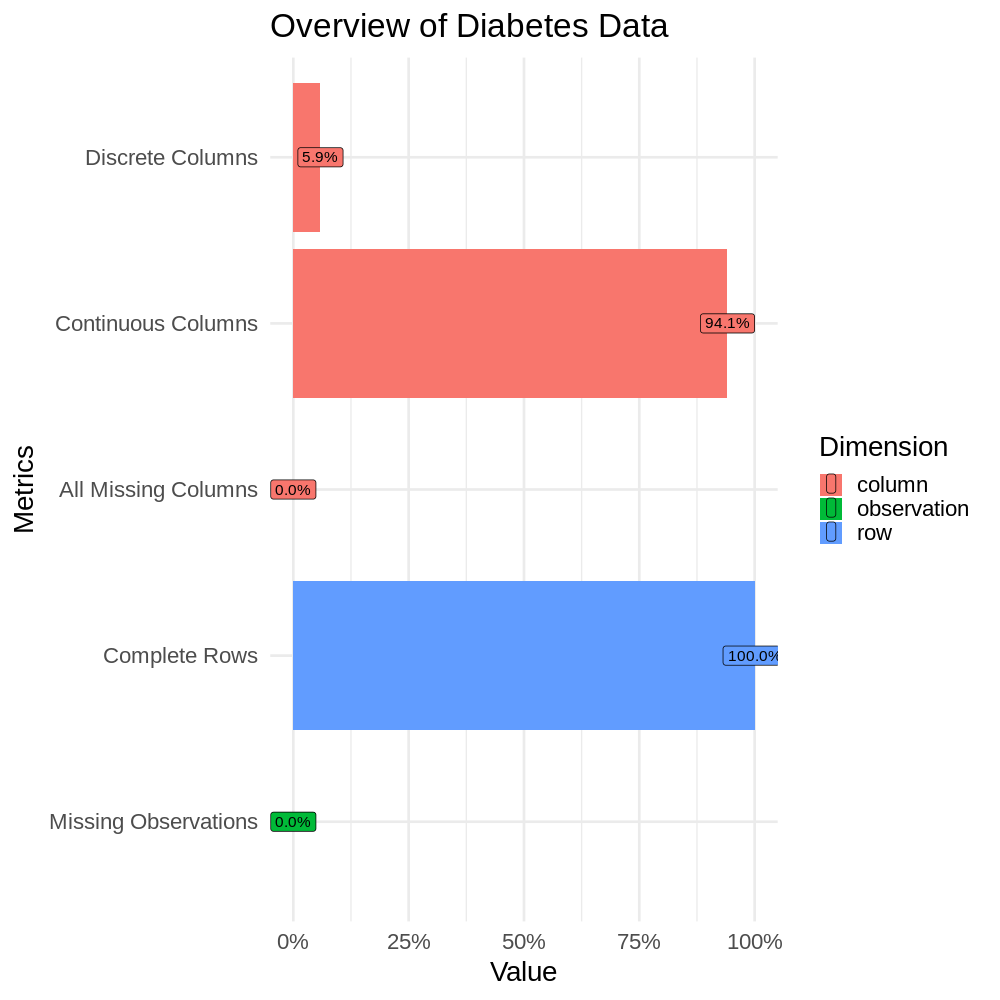

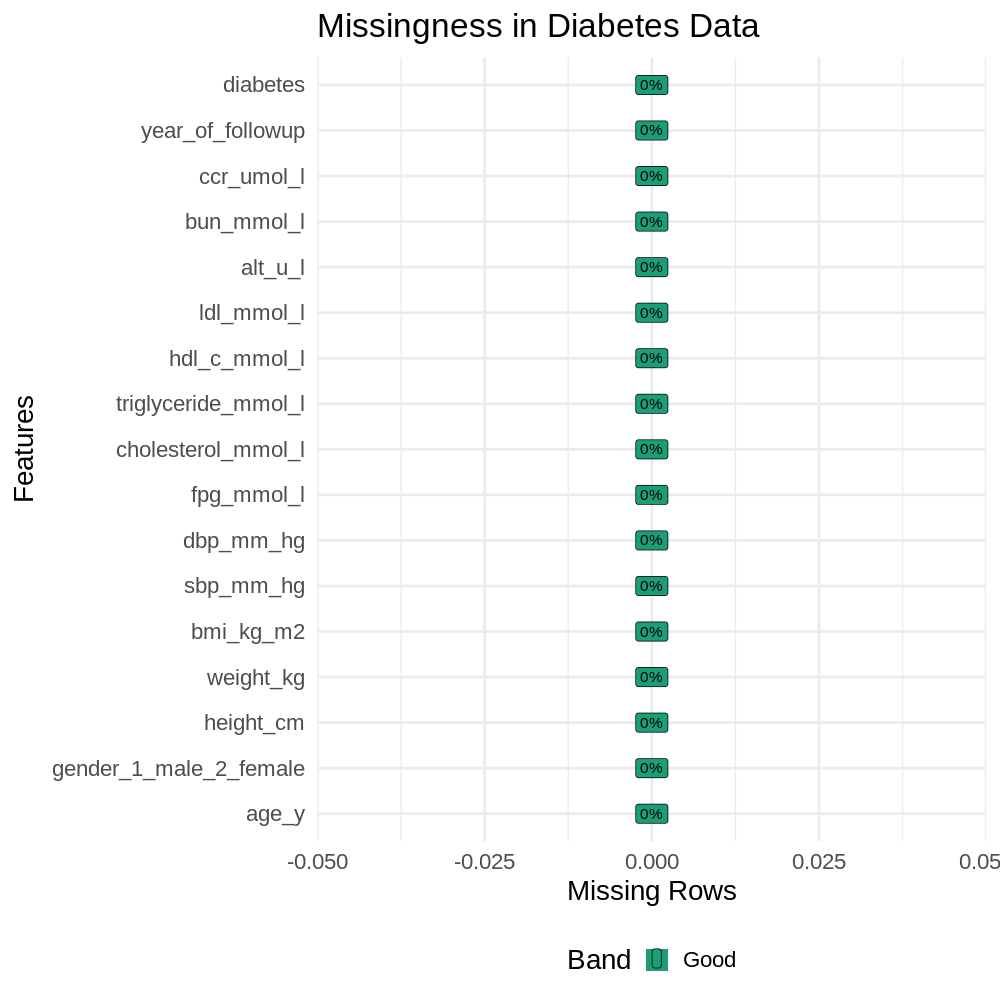

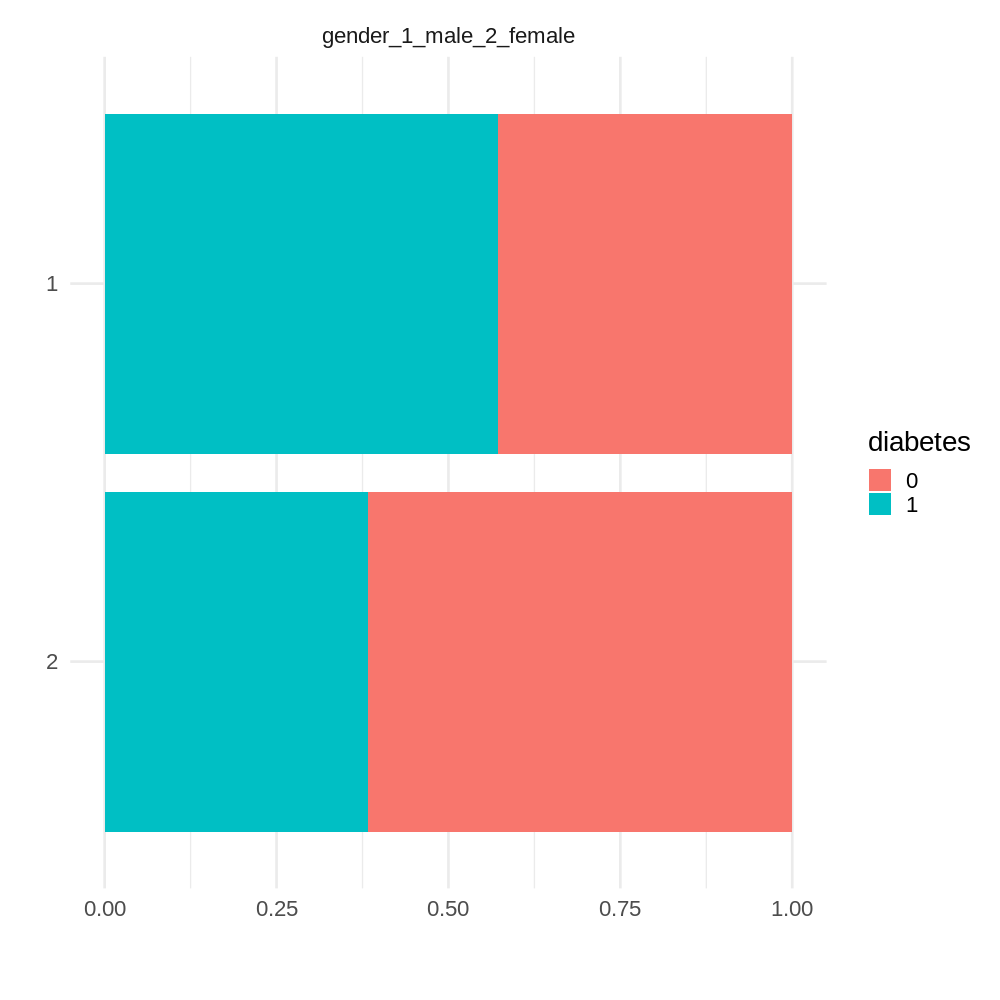

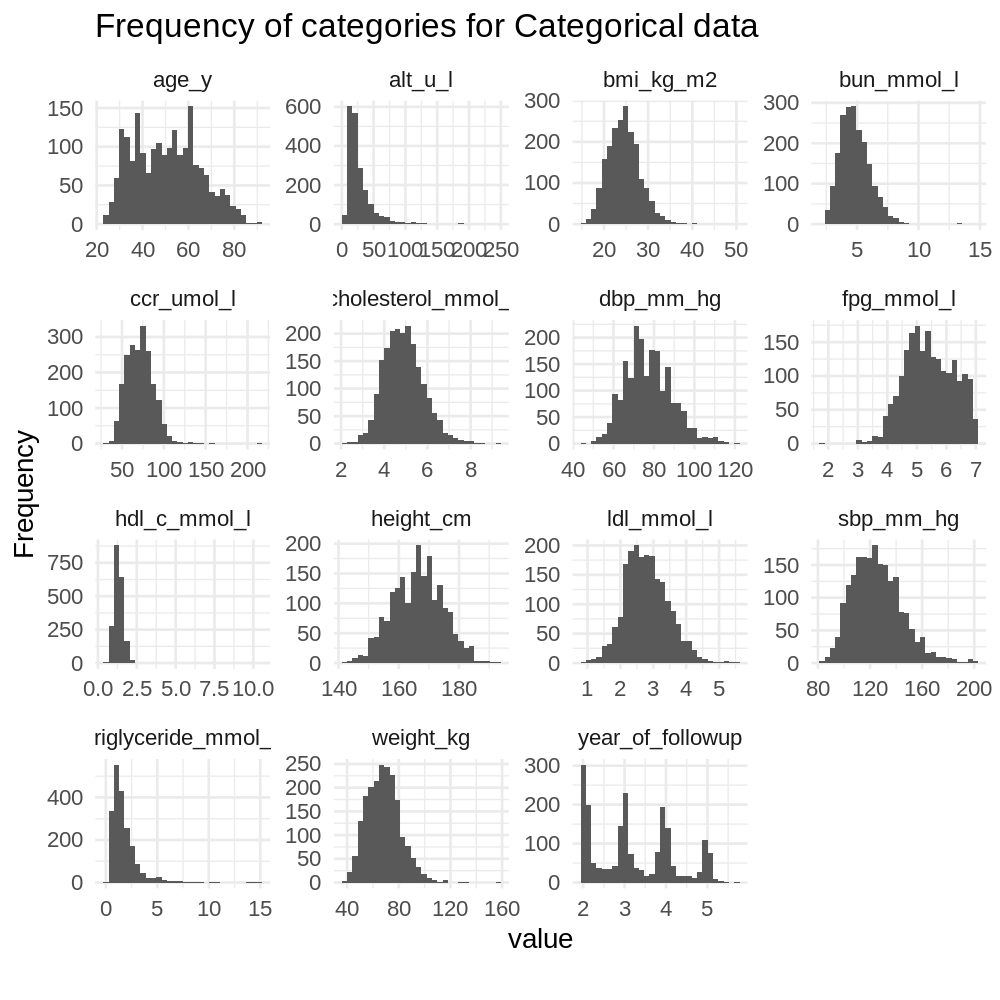

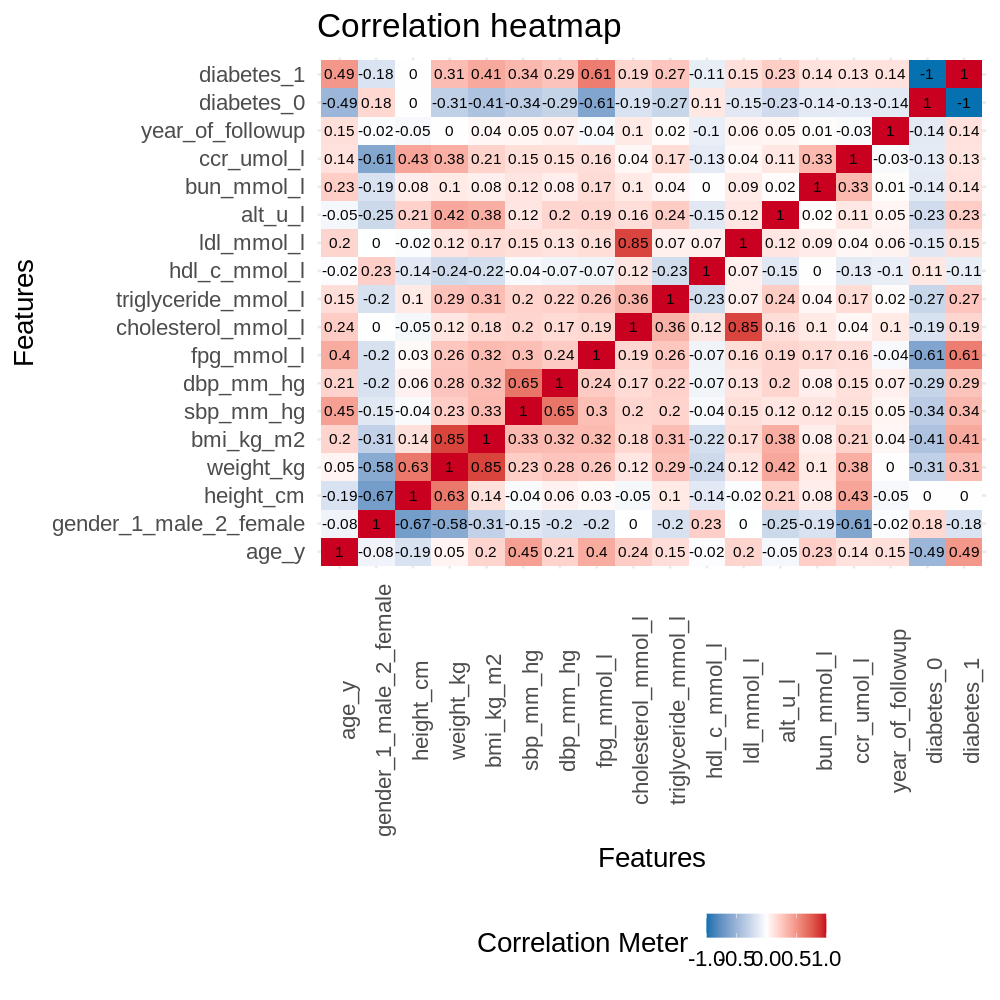

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)
#DataExplorer::create_report(diabetes_train_df)
plot_intro(diabetes_df,
           title = "Overview of Diabetes Data",
           ggtheme = theme_minimal(base_size = 20),
                )
plot_missing(diabetes_df,
           title = "Missingness in Diabetes Data",
           ggtheme = theme_minimal(base_size = 20))

plot_bar(diabetes_df, by="diabetes",
           ggtheme = theme_minimal(base_size = 20))

plot_histogram(diabetes_df,
           title = "Frequency of categories for Categorical data",
           ggtheme = theme_minimal(base_size = 20))

plot_correlation(diabetes_df, maxcat = 5L,
           title = "Correlation heatmap",
           ggtheme = theme_minimal(base_size = 20))

## 1.3 Fitting a model to the data

Lets fit a simple logistic regression to the data and look at how well it makes predictions on the data. The code below will fit a simple logistic regression , using only a single predictor (bmi), to allow for simple plots of the fit, and then using all available features.

We begin by plotting the data, the model fit and some classic summary statistics.

*Questions*:
 - Which features are the most predictive?
 - How much improvement to you get if you combined features compared to a model based on individual features?
 - Try regenerating the dataset with more or less noise. What happens to prediction accuracy as you add more noisy variables?

 Note: the data has a bunch of variables called noise_<number> e.g noise_1, noise_2 etc. These are just randomly generated numbers. But in real life these types of variables do exist - they are essentially any variable that is unrelated to the thing we are trying to predict. In this data, we explicitly know these noise variables but in your own datasets (and for the other variables in the diabetes dataset), we have no idea which variables are related and which are not.



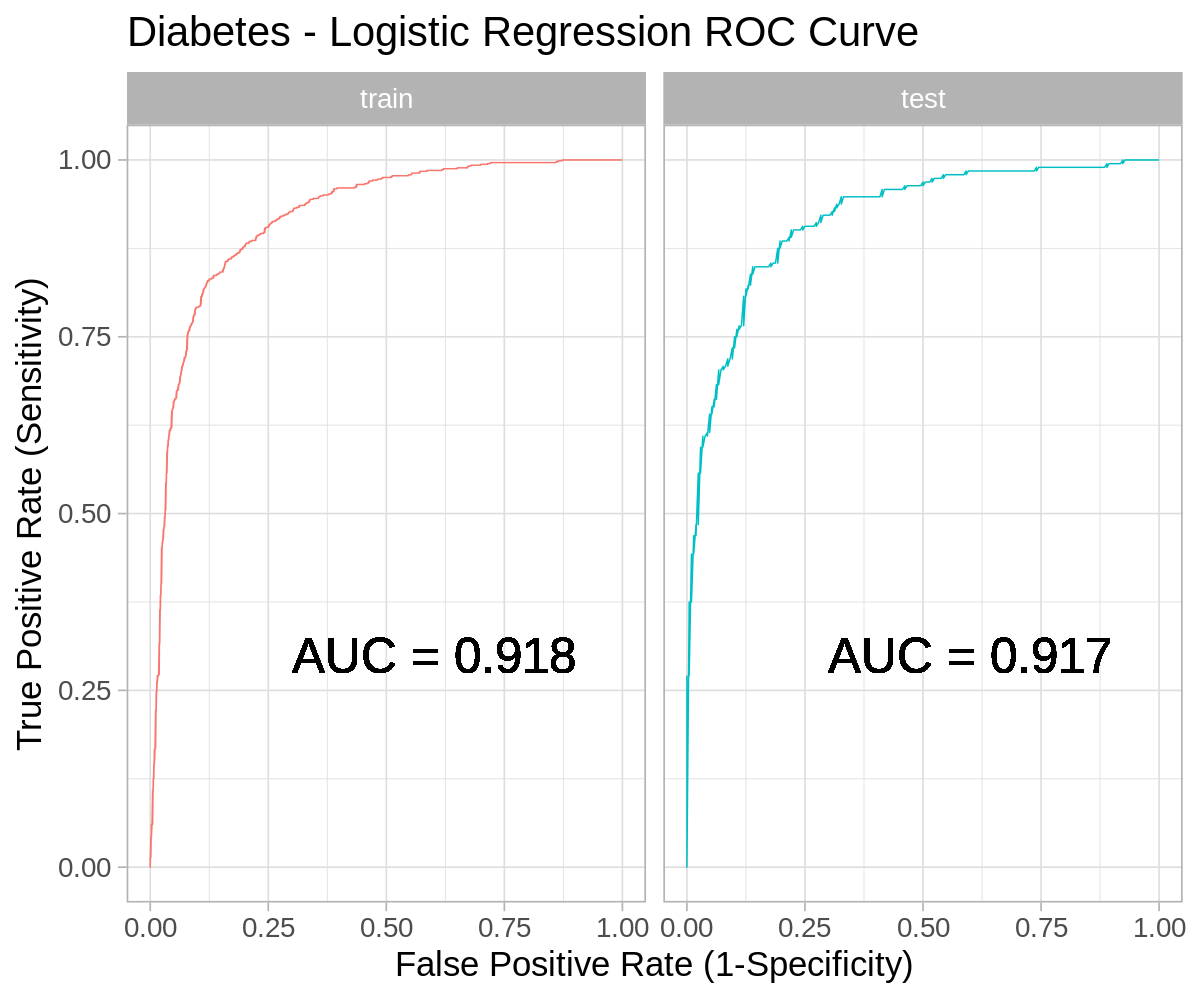

In [7]:
options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 100)

# Setting up the model specification
logit_spec <- logistic_reg(mode = "classification", penalty = 0, engine = "glm")

# Setting up the workflow
workflow <- workflow() %>%
  add_model(logit_spec) %>%
  add_formula(diabetes ~ .) # Any variable on the left-hand side of the tilde (~) is considered the model outcome (here, arr_delay). On the right-hand side of the tilde are the predictors. Variables may be listed by name, or you can use the dot (.) to indicate all other variables as predictors.

# Fitting the model
model_fit <- workflow %>%
         fit(data = diabetes_train_df)

# Make predictions
diabetes_train_preds <- predict(model_fit, diabetes_train_df, type = "prob")
diabetes_test_preds  <- predict(model_fit, diabetes_test_df, type = "prob")

# Pull out the actual labels
diabetes_train_labels <- diabetes_train_df %>% dplyr::select(diabetes)
diabetes_test_labels  <- diabetes_test_df %>% dplyr::select(diabetes)


# Now plot the ROC curves and their AUCs
plot_roc_auc(diabetes_train_preds, diabetes_test_preds,
             diabetes_train_labels, diabetes_test_labels,
             label="Diabetes - Logistic Regression")


## 1.4 Examine top features
Logistic regression provides an interpretable model. To see which features are most important, we can look at the coefficients of each variable. Larger absolute values implies more impact in the predictions.


**Examine the following:**

1. Do any noise variables make it into the top 10?
2. What if you generate lots of noise variables (>1000)


In [20]:
model_fit$fit$fit$fit %>%
  tidy() %>%
  arrange(p.value) %>%
  mutate(rank=1:n()) %>%
  relocate(rank,1) %>%
  slice_head(n=10)

rank,term,estimate,std.error,statistic,p.value
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,fpg_mmol_l,1.80098999,0.120471950,14.949455,1.570291e-50
2,age_y,0.06899440,0.006928653,9.957838,2.330755e-23
3,year_of_followup,0.43419339,0.080574742,5.388704,7.096776e-08
4,alt_u_l,0.01351642,0.003936861,3.433298,5.962872e-04
5,weight_kg,0.16064080,0.078354929,2.050168,4.034800e-02
6,height_cm,-0.13317552,0.066687983,-1.996994,4.582580e-02
7,dbp_mm_hg,0.01443827,0.008858586,1.629862,1.031307e-01
8,cholesterol_mmol_l,-0.31574506,0.195603284,-1.614211,1.064816e-01
9,triglyceride_mmol_l,0.11381557,0.072475483,1.570401,1.163219e-01



# Session 2: More models and metrics in `tidymodels`

In the previous example, we fit a logistic regression model to the given dataset and examine its performance using AUC. However, in many studies where we are looking to create a predictive model, we will be interested in creating multiple models based on different underlying algorithms and possibly evaluating them based on different criteria. Here, we demonstrate how these different models and metrics can be called and provide a few examples with our diabetes dataset as to the information you get.      

## 2.1 Exploring different models
Tidymodels has quite a standardised interface for fitting and applying different models. These standardised interfaces allow us to easily explore the impact of different classifiers for a problem. UNderstanding the different assumptions and methods is beyond this workshop. However, we can explore how this is done and talk through the impact of diffent classifiers.


**Examine the following:**

1. How well do different classifiers perform on the given dataset? Which models maximise performance on the training set? What does external performance look like?
2. Are there noticable timing differences?

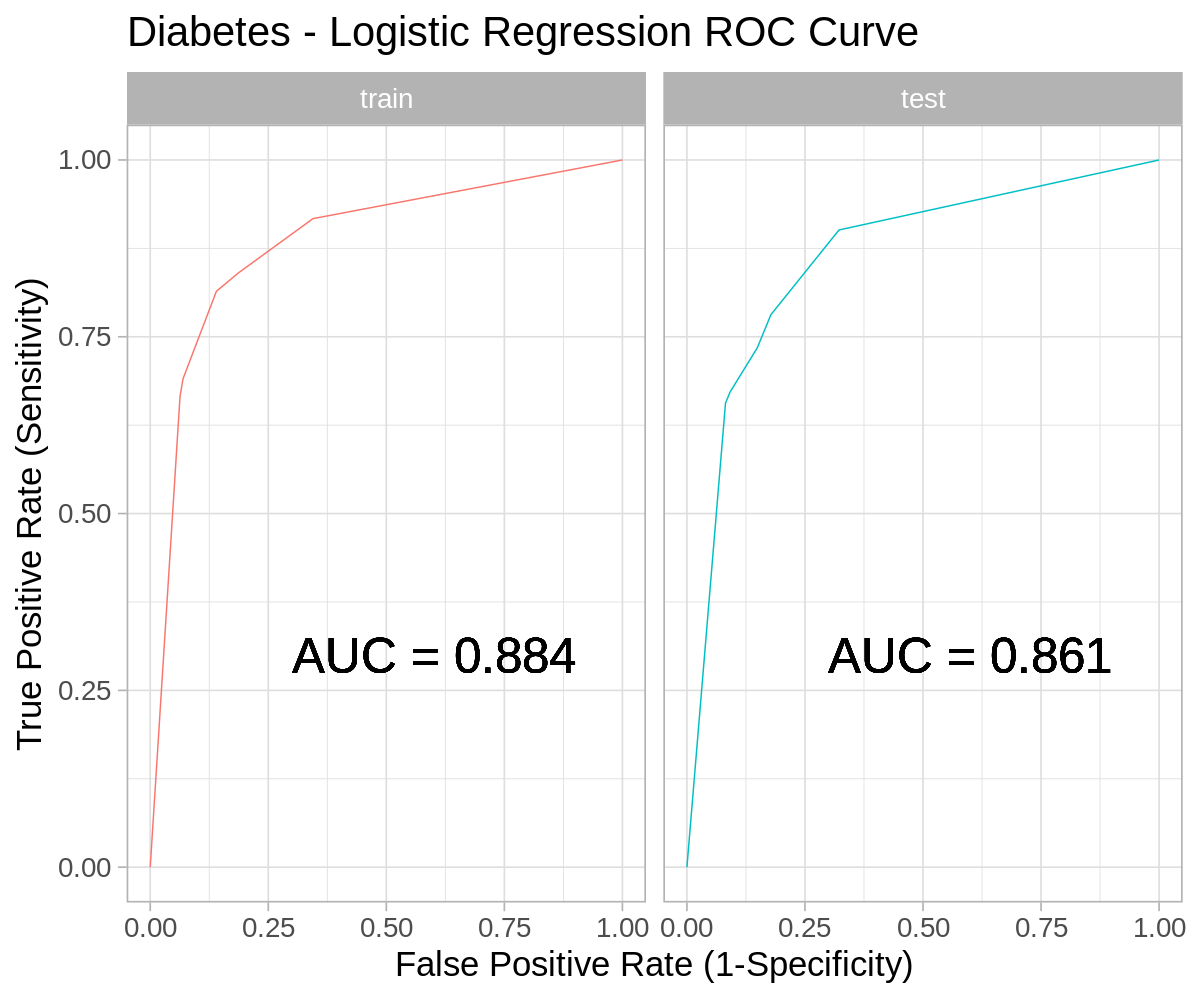

In [21]:
# Define the models
models=list()
models[['log_reg']] = logistic_reg(mode = "classification", penalty = 0) %>%
                             set_engine("glm") %>%
                             set_mode("classification")

models[['lasso']] = logistic_reg(penalty = 0.1, mixture = 1) %>%
                             set_engine("glmnet") %>%
                             set_mode("classification")

models[['rf']] = rand_forest(mtry = 2, trees = 500, min_n = 3) %>%
                             set_engine("randomForest") %>%
                             set_mode("classification")

models[['decision_tree']]= decision_tree(tree_depth = 5) %>%
                             set_engine("rpart") %>%
                             set_mode("classification")

# Select the model of interest
current_model=models[["decision_tree"]] %>% set_mode("classification")

# Fit the model
model_fit <- current_model %>%
  fit(diabetes ~ ., data = diabetes_train_df)

# Make predictions
diabetes_train_preds <- predict(model_fit, diabetes_train_df, type = "prob")
diabetes_test_preds  <- predict(model_fit, diabetes_test_df, type = "prob")

# Pull out the actual labels
diabetes_train_labels <- diabetes_train_df %>% dplyr::select(diabetes)
diabetes_test_labels  <- diabetes_test_df %>% dplyr::select(diabetes)


# Now plot the ROC curves and their AUCs
plot_roc_auc(diabetes_train_preds, diabetes_test_preds,
             diabetes_train_labels, diabetes_test_labels,
             label="Diabetes - Logistic Regression")


## 2.2 Example of a specific model output
Different machine learning methods have very different underlying algorithms and can produce very different outputs.

Below we take an example at a unique output, that of a decision tree, to peek into how it works. Here, the model produces a sort of flowchart for how a sample should be classifier, based on a series of binary decisions. We visualise this model below where each node shows
1. A variable chosen to make a decision and a threshold for which side of the subtree we go down
2. gini value, a measure of how well the given split separates classes (lower is more discriminative)
3. samples is the number of samples in a node in the training data
4. values is the number of samples in each class in the training data (sum of 'values' is the same as 'samples')

**Examine the following:**
1. What happens when we have more or less noise variables in the data? Do they make it into the tree?
2. What if we make the tree bigger or smaller (n=1 or n=5)? How do you think the model will perform
3. Try make the max_depth=7. Is the tree still interpretable? How many noise variables are included

Warning message:
“Cannot retrieve the data used to build the model (so cannot determine roundint and is.binary for the variables).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”
Warning message:
“cex and tweak both specified, applying both”


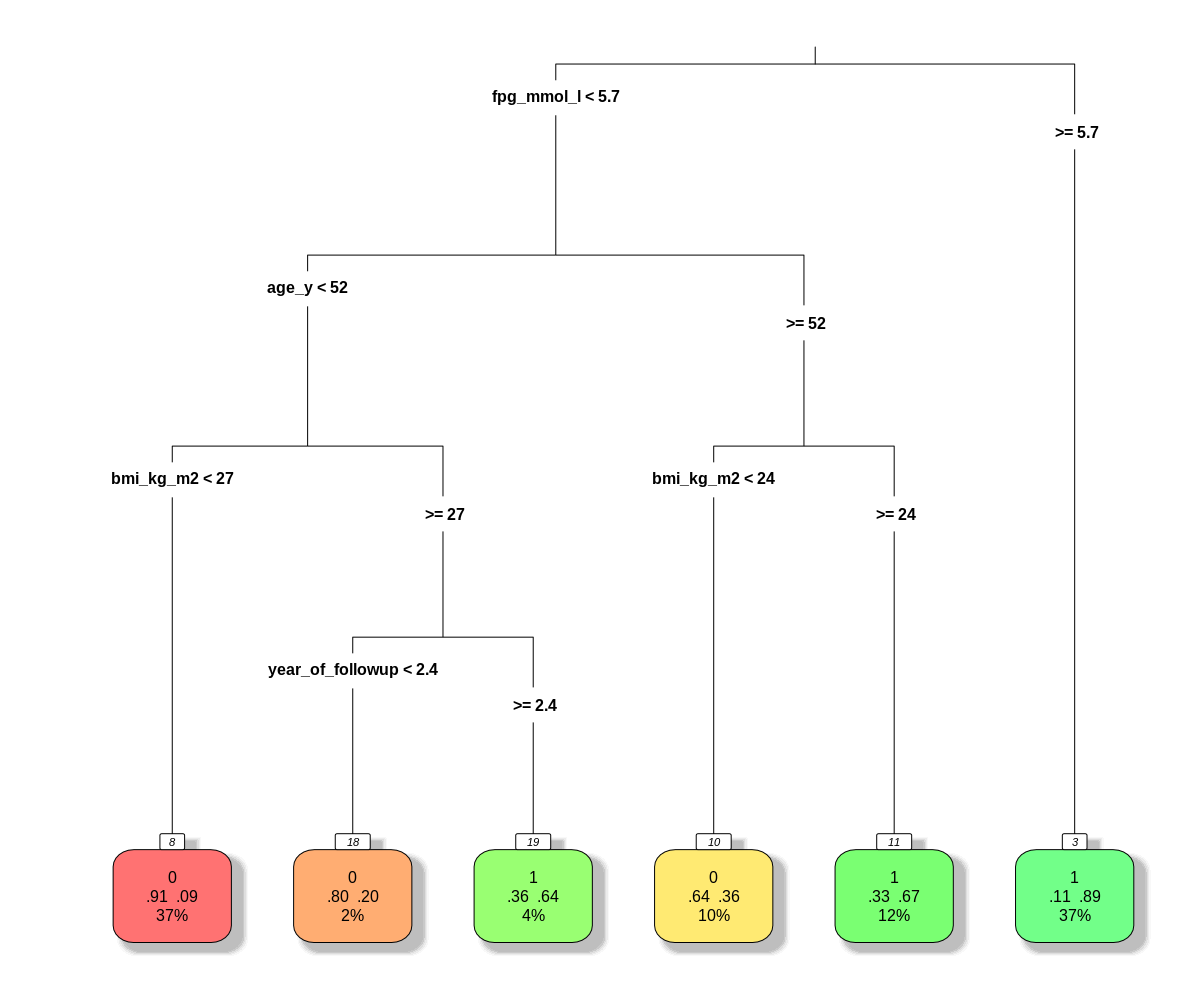

In [23]:
# Define the model
dt_model <- models[['decision_tree']]

# Fit the model
dt_fit <- dt_model %>%
  fit(diabetes ~ ., data = diabetes_train_df, model=T)

# Plot the decision tree
rpart.plot(dt_fit$fit, type = 3, extra = 104, cex = 0.8, fallen.leaves = TRUE, tweak = 1.2,
           box.palette = "RdYlGn", shadow.col = "gray", nn = TRUE)

## 2.3 Exploring different metrics

We can also change the way that we evaluate model performance, again through the standardised interface provided by scikit-learn

A list of possible options are provided can be see at
https://yardstick.tidymodels.org/articles/metric-types.html

Examine the following:

1. Do different metrics ever change the ranking of which methods are best?
2. How do results compare on the internal and external predictions? Are they the same? Do they dramatically differ?
3. What happens when you adjust the amount of noise variables in the dataset?

In [24]:
train_test_split_rset <- initial_split_to_rset(train_test_split, diabetes_df)
metrics_dict <- metric_set(accuracy, bal_accuracy, roc_auc, mn_log_loss)

multi_model_workflow <-  workflow_set(
    preproc = list("formula" = diabetes ~ .),
    models = models
  )

# Fit models with resampling and pass options
results <- multi_model_workflow %>%
  workflow_map(
    "fit_resamples",
    resamples = train_test_split_rset,
    metrics = metrics_dict,
    control = control_resamples(save_pred = TRUE)
  )

# Collect the metrics
metrics <- results %>%
  collect_metrics(summarize=FALSE)

# Print the performance table
# NB: The pivoting here should actually be done automatically
# in tune::collect_metrics but I couldn't get it working.
metrics %>%
  pivot_wider(id_cols=c(wflow_id,id),
  names_from = `.metric`, values_from = `.estimate` ) %>%
  filter(id=='Training') %>%
  knitr::kable(digits=3, format='simple')

metrics %>%
  pivot_wider(id_cols=c(wflow_id,id), names_from = `.metric`, values_from = `.estimate` ) %>%
  filter(id=='Testing') %>%
  knitr::kable(digits=3, format='simple')




wflow_id                id          accuracy   bal_accuracy   roc_auc   mn_log_loss
----------------------  ---------  ---------  -------------  --------  ------------
formula_log_reg         Training       0.851          0.851     0.918         0.365
formula_lasso           Training       0.825          0.825     0.903         0.462
formula_rf              Training       0.999          0.999     1.000         0.138
formula_decision_tree   Training       0.837          0.837     0.884         0.407



wflow_id                id         accuracy   bal_accuracy   roc_auc   mn_log_loss
----------------------  --------  ---------  -------------  --------  ------------
formula_log_reg         Testing       0.848          0.848     0.917         0.364
formula_lasso           Testing       0.828          0.827     0.904         0.462
formula_rf              Testing       0.845          0.844     0.916         0.382
formula_decision_tree   Testing       0.795          0.793     0.861         0.456

# Session 3: Train/test and cross-validation frameworks

In the previous example, we built model on entire dataset and evaluated its performance on the same data. Here, we will explore some alternative frameworks for doing this and will evaluate how model performance changes. We'll also start to explore different models and how key parameters can be altered to change prediction performance.

## 3.1 Training and Test split

The following code examines training and testing a model on a single dataset and compares its performance to an external dataset in 3 scenarios:
 - Training on the entire dataset. Test on the same entire dataset.
 - Training on a proportion (default 80%). Test on the same proportion.
 - Training on a proportion (default 80%). Test on the remaining proportion.

**Questions:**
1. Run this cell a few times. Which accuracies change? Why?
2. Which evaluation scenario is closest to the external data performance?
2. What is the best performance you observe without changing parameters? What is the worst performance you observe?
3. What happens to test performance as you add more noise variables?
4. Try changing parameters ('C' for the l2 penalized logistic regression, or max_depth for Random Forest)

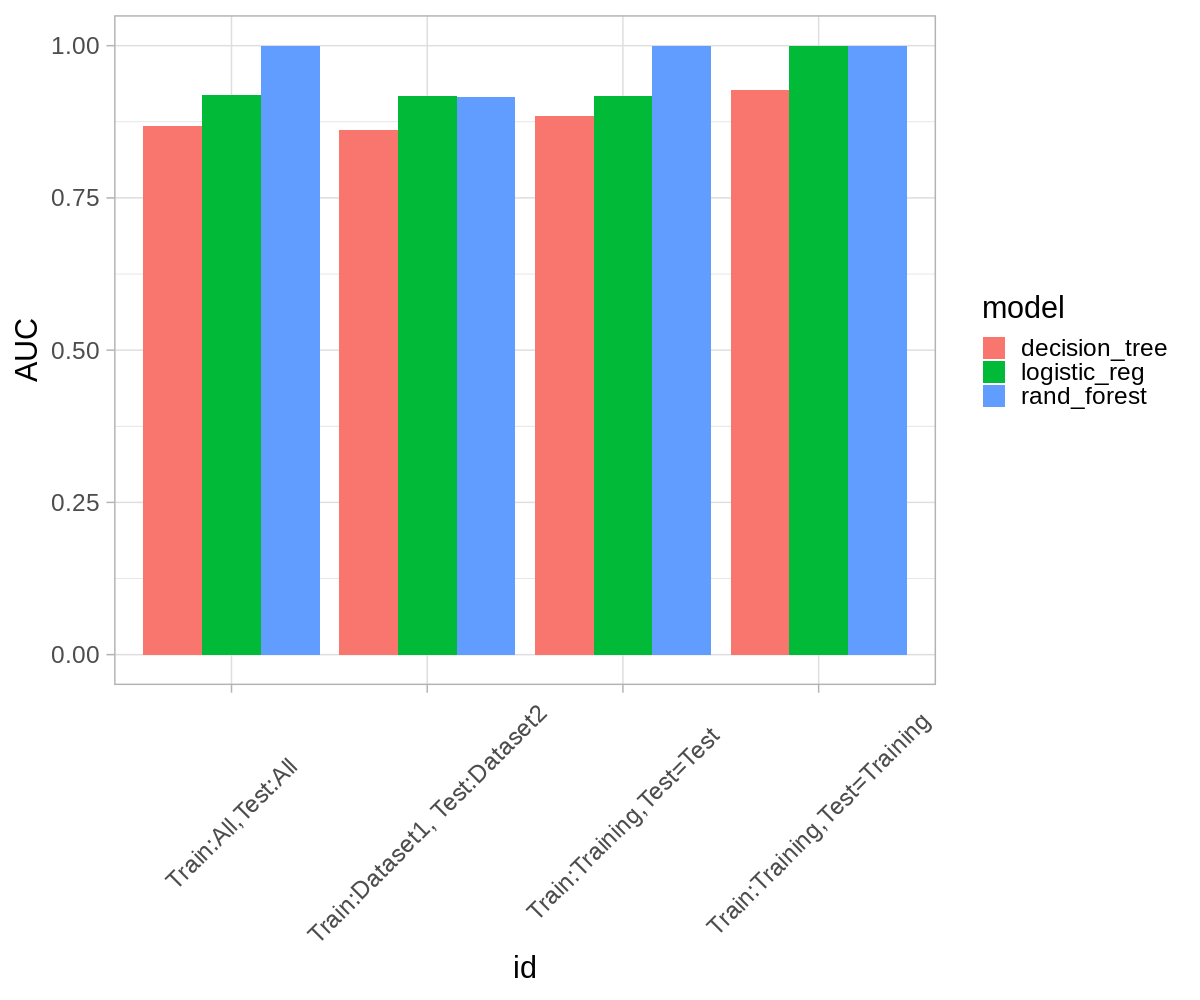

In [25]:
# Setup three types of splits
# 1 Where we train on everything
# 2 Where we train on the trianing data and test on the training data
# 3 Where we train on the training data and test on the test data
train_test_split_rset <- initial_split_to_rset(train_test_split, diabetes_df, all=T, df2=diabetes_study2_df)

metrics_dict <- metric_set(roc_auc)

multi_model_workflow <-  workflow_set(
    preproc = list("formula" = diabetes ~ .),
    models = models
  )

# Fit models with resampling and pass options
results <- multi_model_workflow %>%
  workflow_map(
    "fit_resamples",
    resamples = train_test_split_rset,
    metrics = metrics_dict,
    control = control_resamples(save_pred = TRUE)
  )

# Collect the metrics
metrics <- results %>%
  tune::collect_metrics(summarize=FALSE)

metrics %>%
  ggplot(aes(x=id, y=.estimate, fill=model)) +
  geom_col(position='dodge') +
    theme_light(base_size=22) +
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5)) +
  ylab("AUC")



## 3.2 K-fold Cross-validation
Variability in the performance of different splits in the previous example motivates the use of K-fold cross validation. Here, we explore a few models and start to compare model performance.  

***Warning***: Be careful setting the values below. Setting the number of times to evaluate the classifiers too high and it will take too long to run for this workshop.

**Questions:**
1. Run this cell a few times. What is the range of the scores that are observed?
2. Which model is the best? How do you determine this?
3. Play around with hyperparameters, what is the impact on model performance? Which models are sensitive to these choices?


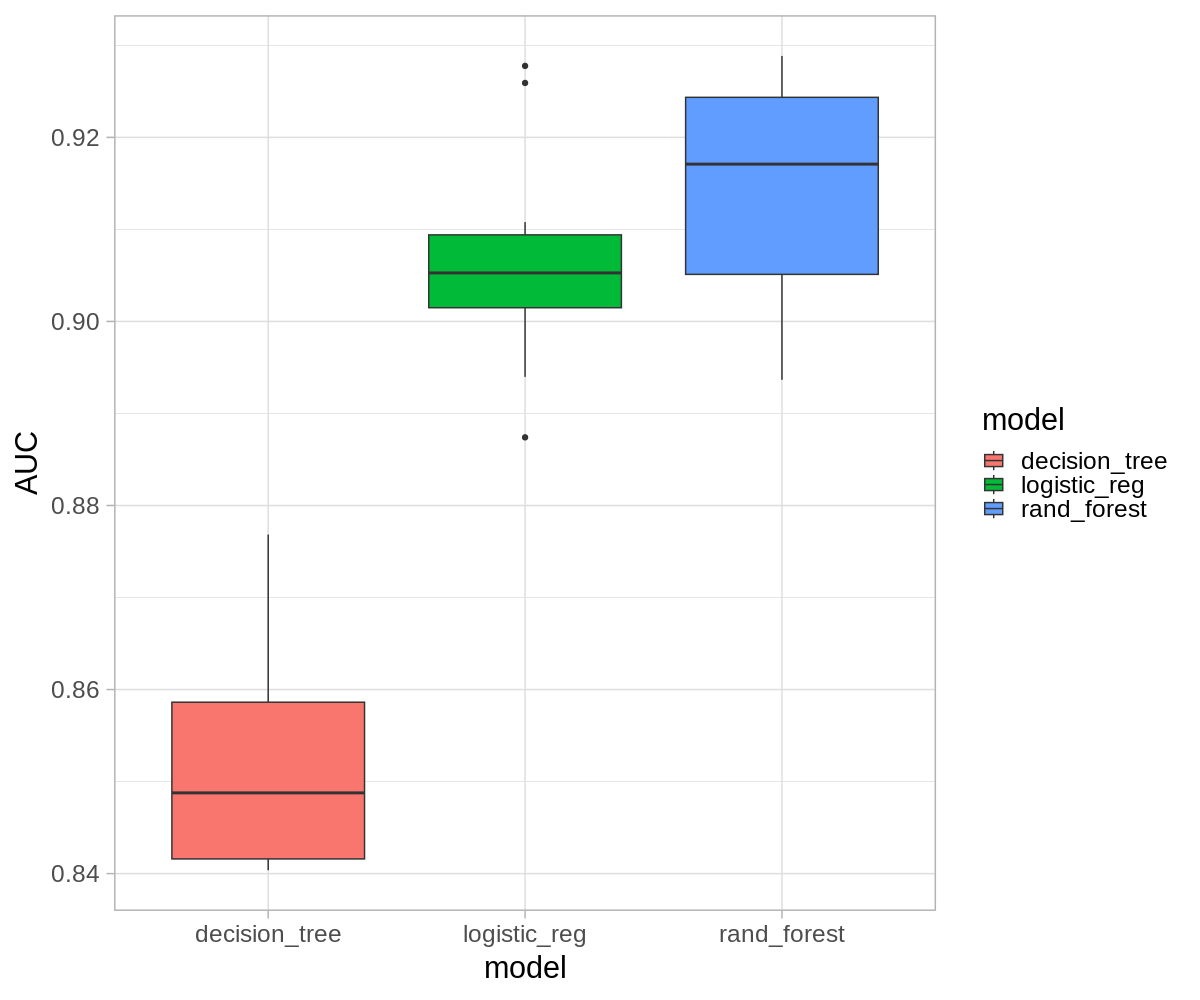

In [26]:
metrics_dict <- metric_set(roc_auc)

multi_model_workflow <-  workflow_set(
    preproc = list("formula" = diabetes ~ .),
    models = models
  )

# K-fold cross-validation
kfold=vfold_cv(diabetes_df, v = 3, repeats = 2)

# Fit models with resampling and pass options
results <- multi_model_workflow %>%
  workflow_map(
    "fit_resamples",
    resamples = kfold,
    metrics = metrics_dict,
    control = control_resamples(save_pred = TRUE)
  )

# Collect the metrics
metrics <- results %>%
  tune::collect_metrics(summarize=FALSE)

metrics %>%
  ggplot(aes(x=model, y=.estimate, fill=model)) +
  geom_boxplot(position='dodge') +
  ylab("AUC") + theme_light(base_size=22)

# Session 4. Overfitting via feature selection and model parameters


## 4.1 Feature discrimination over entire dataset
One naive way to remove noise is to look at the features one-by-one,  look at their ability to discriminate the dataset and only take the most useful into our model. This is flawed but is common in the literature.

Lets take a look at the discriminatory ability of our features, here using significance from a logistic regression. We report the coefficient (as a measure of effect size) and p-value for each features.

**Question:**
1. How do measured and noise features compare?
2. What if we generate lots (n=10,000) noise features? How often can we distinguish noise and real signal?

In [27]:
sapply(setdiff(colnames(diabetes_df), 'diabetes'), \(nm) {
  res=coef(summary(glm(str_c('diabetes~',nm), family = 'binomial', data = diabetes_df)));
  data.frame(feature=nm, beta=res[1,4], pvalue=res[2,4])},
simplify = F ) %>%
bind_rows() %>%
arrange(pvalue) %>%
slice_head(n=10)

feature,beta,pvalue
<chr>,<dbl>,<dbl>
fpg_mmol_l,7.655651e-114,2.843013e-114
age_y,1.440588e-84,2.942083e-88
bmi_kg_m2,1.816002e-62,6.494401e-63
sbp_mm_hg,3.096505e-46,1.563611e-46
weight_kg,3.239934e-40,5.376587e-41
dbp_mm_hg,4.405842e-34,1.639672e-34
triglyceride_mmol_l,8.511460e-26,1.663159e-30
alt_u_l,2.201524e-18,1.463740e-22
cholesterol_mmol_l,8.088867e-17,3.044550e-17


## 4.2 Demonstrating potential overfitting when selecting features before CV
Given we've ranked the features in terms of their discrinatory ability, we could now select some top amount (based on p-value, f-statistic or a feeling for how many features we need).

But such an approach uses all of the information, and hence means there is no unsed data left for an untouched test set.

To explore this impact, the code below plots classifier performance starting with a single most discrinimatory feature and increasing to the top 32 features. We plot the model performance in training and testing.

Additionally, we plot the performance of constructing a model on all samples and evaluating the external dataset to show where the ideal would be.

**Questions**
1. What are the trends in the performance of the model on the training data as we increase features?
2. What are the trends in the performance of the model on the test data as we increase features?
3. Where is the ideal number of features for the external data?
4. How often does number of features to achieve the highest "test" performance correspond to the hihgest external performance?
5. What happens if you run this cell a few times? How do results differ? Why do they change?


## 4.3 Nested cross-validation for feature selection and hyperparameter tuning

Rather than selecting the number of features to be included in a model (based on a random guess, or worse peeking at test results), we can instead conduct feature selection as part of cross validation.

The code below runs two cross-validation loops (inner and outer), essentially running one loop on the training data (repeatededly breaking it into training and validation datasets) to understand how the number of features impacts performance. We then select the best number of features and evaluate the held-out testset. This is then repeated for the number of folds in the outer loop.

While robust, the approach can be computationally expensive as we are building many models.

**Warning** This code will take a few minutes. If you add in hyperparameter selection (by uncommenting param_grid),  this could take quite a while to run in Google Colab.

**Questions:**
1. Try generating a dataset with no noisy features and one with many? How much does performance vary?
2. How does performance vary if we change from a penalized regression to a random forest?

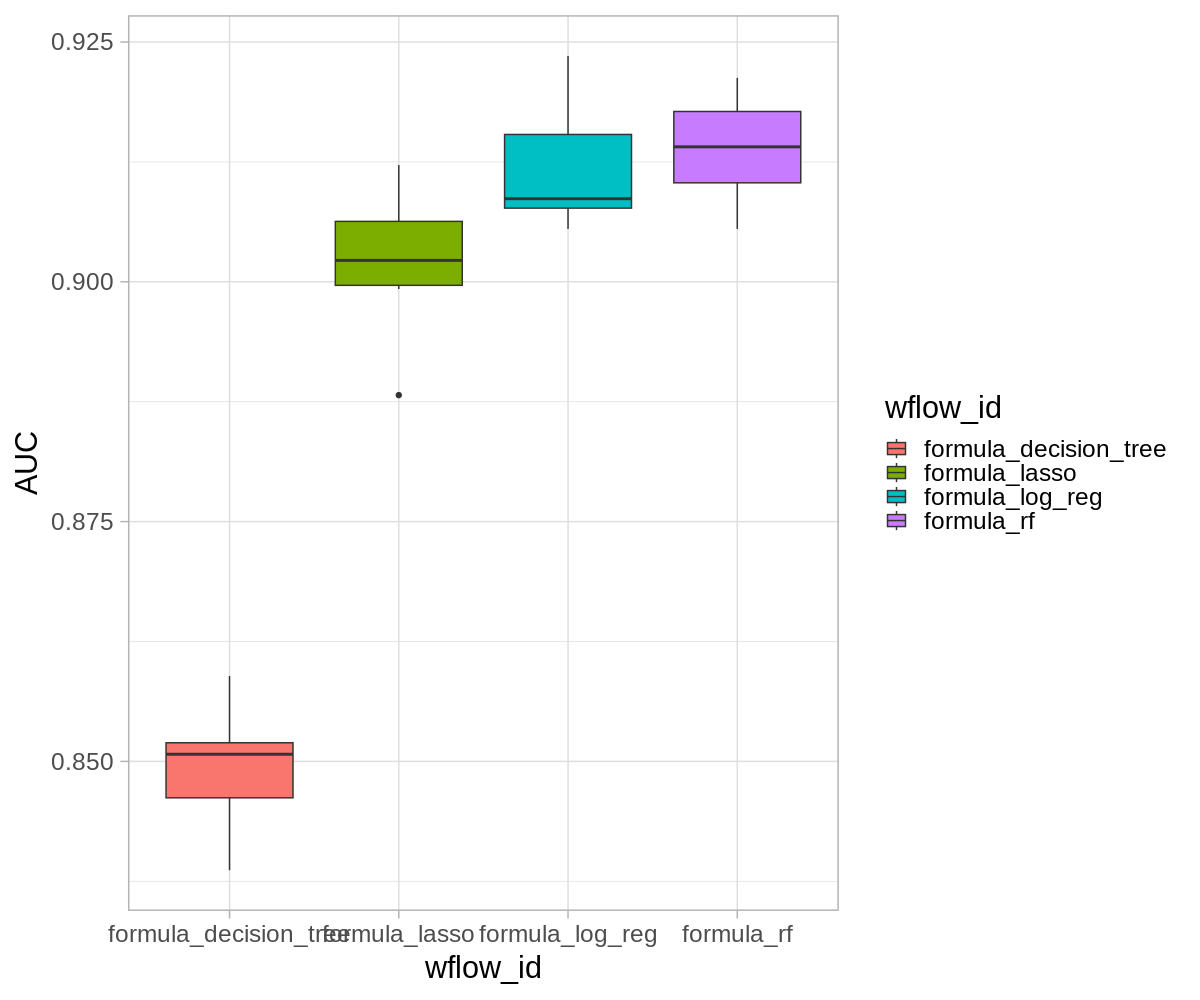

In [30]:

# Define models with some parameters for tuning
models <- list()
models[['log_reg']] <- logistic_reg(mode = "classification", penalty = tune()) %>%
  set_engine("glm")

models[['lasso']] <- logistic_reg(penalty = tune(), mixture = 1) %>%
  set_engine("glmnet")

models[['rf']] <- rand_forest(mtry = tune(), trees = 500, min_n = tune()) %>%
  set_engine("randomForest")

models[['decision_tree']] <- decision_tree(tree_depth = tune()) %>%
  set_engine("rpart")

# Define the tuning grids
log_reg_grid <- grid_regular(penalty(), levels = 10)
lasso_grid <- grid_regular(penalty(), levels = 10)
rf_grid <- grid_regular(mtry(range = c(1, 5)), min_n(range = c(1, 5)), levels = 10)
decision_tree_grid <- grid_regular(tree_depth(), levels = 10)

#d cross-validation
kfold <- vfold_cv(diabetes_df, v = 3, repeats = 2)

# Fit models with tuning and pass options
results <- multi_model_workflow %>%
  workflow_map(
    "tune_grid",
    resamples = kfold,
    grid = list(
      log_reg = log_reg_grid,
      lasso = lasso_grid,
      rf = rf_grid,
      decision_tree = decision_tree_grid
    ),
    metrics = metrics_dict,
    control = control_grid(save_pred = TRUE)
  )

# Collect the metrics
metrics <- results %>%
  tune::collect_metrics(summarize = FALSE)

# Plot the metrics
metrics %>%
  ggplot(aes(x = wflow_id, y = .estimate, fill = wflow_id)) +
  geom_boxplot(position = "dodge") +
  ylab("AUC") +
  theme_light(base_size = 22)

## Final task
Using the above code, can you implement a scheme to answer the question "do blood serum markers help predict diabetes progression beyond age, sex, bmi and blood glucose?".

Steps:
 - Copy the code in the previous section
 - Add call to a model with a specified feature subset (as in section Cell 1.3)
 - Compare boxplots from these two models